# Applied Data Science Capstone
## The Battle of Neighborhoods - Week 2
---


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
import requests # library to handle requests
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
#from IPython.display import display

#!pip install BeautifulSoup4
import bs4
from bs4 import BeautifulSoup

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print("\nLibrairies installed and ready to use !")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following NEW packages will be INSTALLED:

    altair:  2.3.0-py36_1001 conda-forge
    branca:  0.3.1-py_0      conda-forge
    folium:  0.5.0-py_0      conda-forge
    vincent: 0.4.4-py_1      conda-forge

Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Librairies installed and ready to use !


Printing packages version

In [2]:
# Versions of main packages

print("Versions:")
print("NUMPY: " + str(np.__version__))
print("PANDAS: " + str(pd.__version__))
print("REQUESTS: " + str(requests.__version__))
print("JSON: " + str(json.__version__))
print("BEAUTIFULSOUP: " + str(bs4.__version__))
print("MATPLOTLIB: " + str(mpl.__version__))
print("SKLEARN: " + str(sk.__version__))

Versions:
NUMPY: 1.15.4
PANDAS: 0.23.4
REQUESTS: 2.20.1
JSON: 2.0.9
BEAUTIFULSOUP: 4.6.3
MATPLOTLIB: 2.2.2
SKLEARN: 0.20.1


## STEP 1 - Get data from Wikipedia  
---
In this part of the script, I scrape all the demographic data about Toronto from the following Wikipedia page :
https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods

In [3]:
# Use the link from wikipedia with BeatifulSoup to import the demographic data
demographic_link =  'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'

source = requests.get(demographic_link).text
soup = BeautifulSoup(source, 'lxml')

wiki_table = soup.find('table', class_='wikitable sortable')

In [4]:
# Data scraping

headers = []
for th in wiki_table.find_all('th'):
    headers.append(th.text)

data = []
for td in wiki_table.find_all('td'):
    data.append(td.text)

Neighborhood = []
for nb in range (13,len(data),13):
    Neighborhood.append(data[nb])

Population = []
for pop in range (16,len(data),13):
    Population.append(data[pop])

Density = []
for den in range (18,len(data),13):
    Density.append(data[den])

Average_income = []
for income in range (20,len(data),13):
    Average_income.append(data[income])

# Clear data
#'45,792Canada 2011 Census[1]\n'
x,y = Average_income[63].split('Canada')
Average_income[63] = x
Average_income[63]

Second_language_percentage = []
Second_language_name = []

for language in range (24,len(data),13):
    num, name = data[language].split('%')
    Second_language_percentage.append(num)
    Second_language_name.append(name)    

# Create the dataframe for the chosen columns from wiki link
# Further clearing the data and transform to the correct data types, e.g. int/float,etc.
# Save the file to'demographic.csv'

d1 = {'Neighborhood': Neighborhood, 
      'Population': Population, 
      'Density':Density, 
      'Average income':Average_income,
      'Second language after English, %':Second_language_percentage,
      'Second language after English, name':Second_language_name
     }

demographic = pd.DataFrame(d1)
demographic.replace(r'\n', '', regex = True, inplace = True)
demographic.replace(',', '', regex = True, inplace = True)
demographic['Second language after English, name'] = demographic['Second language after English, name'].str.lstrip()
demographic['Population'] = demographic['Population'].astype(int)
demographic['Density'] = demographic['Density'].astype(int)
demographic['Average income'] = demographic['Average income'].astype(int)
demographic['Second language after English, %'] = demographic['Second language after English, %'].astype(float)

# Create new column with the population speaking second language after English
demographic['Second language population'] = (demographic['Population'] * (demographic['Second language after English, %'] / 100)).astype(int)

# Assume Unspecified Chinese as Chinese
demographic['Second language after English, name'] = demographic['Second language after English, name'].str.replace('Unspecified Chinese', 'Chinese' )

# Remove 'Toronto island' since it has 'any' as language (undetermined ethnicity)
demographic = demographic[demographic['Neighborhood'] !='Toronto Islands']

# Print the 10 first lines
demographic.head(10)

,Neighborhood,Population,Density,Average income,"Second language after English, %","Second language after English, name",Second language population
0,Agincourt,44577,3580,25750,19.3,Cantonese,8603
1,Alderwood,11656,2360,35239,6.2,Polish,722
2,Alexandra Park,4355,13609,19687,17.9,Cantonese,779
3,Allenby,2513,4333,245592,1.4,Russian,35
4,Amesbury,17318,4934,27546,6.1,Spanish,1056
5,Armour Heights,4384,1914,116651,9.4,Russian,412
6,Banbury,6641,2442,92319,5.1,Chinese,338
7,Bathurst Manor,14945,3187,34169,9.5,Russian,1419
8,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459
9,Bayview Village,12280,2966,46752,8.4,Cantonese,1031


In [5]:
# Read the coordinates per neighborhood
Toronto_neighborhood = pd.read_csv('List_neighborhood_Toronto.csv')

# Merge the two dataframes in order to get the coordinates for neighborhoods from Toronto
Toronto = pd.merge(demographic, Toronto_neighborhood, on='Neighborhood', how='inner')
Toronto.rename(index=str, columns={"Second language after English, %": "Percentage", "Second language after English, name": "Language"}, inplace=True)

# Print the 10 first rows
Toronto.head(10)

,Neighborhood,Population,Density,Average income,Percentage,Language,Second language population,Latitude,Longitude
0,Alexandra Park,4355,13609,19687,17.9,Cantonese,779,43.71627,-79.40555
1,Allenby,2513,4333,245592,1.4,Russian,35,43.71275,-79.54746
2,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459,43.65777,-79.38619
3,Bedford Park,13749,6057,80827,0.7,Greek,96,43.73138,-79.42116
4,Bloor West Village,5175,6993,55578,3.6,Ukrainian,186,43.65936,-79.48543
5,Bracondale Hill,5343,8618,41605,4.8,Greek,256,43.67600,-79.42803
6,Brockton,9039,8217,27260,19.9,Portuguese,1798,43.66055,-79.40531
7,Cabbagetown,11120,7943,50398,1.6,Chinese,177,43.66763,-79.36606
8,Carleton Village,6544,8843,23301,17.0,Portuguese,1112,43.67200,-79.45700
9,Casa Loma,3597,5369,82203,1.8,Korean,64,43.67000,-79.41000


In [6]:
# Create a map of Toronto using latitude and longitude values, 
# where the neighborhoods of Toronto are shown, and the most common language after English in that area.

map_Toronto_neighborhoods = folium.Map(location=[43.653963, -79.387207], zoom_start=12)

# Use different colors for each language
colors =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'cyan', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

lang = Toronto['Language'].unique()
CLR = dict(zip(lang,colors))

# add markers to map
for lat, lng, nb, lang, perc in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighborhood'],Toronto['Language'],Toronto['Percentage']):
    folium.Marker(location=[lat,lng],
                  popup='{} ({}% {})'.format(nb,perc,lang),
                  icon=folium.Icon(CLR[lang])).add_to(map_Toronto_neighborhoods) 
    
map_Toronto_neighborhoods

## STEP 2 - Get data from Foursquare's API
---
In this part of the script, I get all data needed from Foursquare's API.

In [7]:
# Foursquare credentials for using the API
CLIENT_ID = 'WCHFU3HY4NNFGRE1VRGNK001RSK1ZSDZSDGSIZGXCDH4SUQL' # your Foursquare ID
CLIENT_SECRET = 'GX0J2VLKPW0JHA2B3SUFKOAZ5JIQJQ5YXCC5SILM0VHFG2PK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Use radius 1000 from neighborhood centers and limit to 100 venues.
radius = 1000
LIMIT = 100

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    x = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(x, name)
        x = x+1    
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Identify all the venues per neighborhood in Old Toronto's neighborhoods
Toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude'])

# Print the 10 first rows of Toronto_venues
print("\n")
Toronto_venues.head(10)

0 Alexandra Park
1 Allenby
2 Bay Street Corridor
3 Bedford Park
4 Bloor West Village
5 Bracondale Hill
6 Brockton
7 Cabbagetown
8 Carleton Village
9 Casa Loma
10 Chaplin Estates
11 Christie Pits
12 Church and Wellesley
13 Corktown
14 Davenport
15 Davisville
16 Deer Park
17 Discovery District
18 Distillery District/West Don Lands
19 Dovercourt Park
20 Dufferin Grove
21 Earlscourt
22 East Danforth
23 Fashion District
24 Financial District
25 Forest Hill
26 Fort York/Liberty Village
27 Garden District
28 Grange Park
29 Harbord Village
30 Harbourfront / CityPlace
31 High Park North
32 Junction Triangle
33 Kensington Market
34 Lawrence Park
35 Leslieville
36 Little Italy
37 Little Portugal
38 Lytton Park
39 Moore Park
40 Niagara
41 Parkdale
42 Playter Estates
43 Port Lands
44 Regal Heights
45 Regent Park/Trefann Court
46 Riverdale
47 Roncesvalles
48 Rosedale
49 Seaton Village
50 South Hill
51 St. James Town
52 Summerhill
53 Swansea
54 The Annex
55 The Beaches
56 The Danforth
57 The Junction

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra Park,43.71627,-79.40555,Sheridan Nurseries,43.719005,-79.400500,Flower Shop
1,Alexandra Park,43.71627,-79.40555,Himalayan Java,43.713486,-79.399811,Café
2,Alexandra Park,43.71627,-79.40555,De Mello Palheta Coffee Roasters,43.711791,-79.399403,Coffee Shop
3,Alexandra Park,43.71627,-79.40555,Uncle Betty's Diner,43.714452,-79.400091,Diner
4,Alexandra Park,43.71627,-79.40555,Douce France,43.711534,-79.399255,Bakery
5,Alexandra Park,43.71627,-79.40555,Starbucks,43.711200,-79.399182,Coffee Shop
6,Alexandra Park,43.71627,-79.40555,Alexander Muir Memorial Gardens,43.721315,-79.400822,Garden
7,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant
8,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant
9,Alexandra Park,43.71627,-79.40555,DAVIDsTEA,43.709765,-79.398941,Tea Room


In [10]:
# Keep only the venues that are 'Restaurants'
target_category = 'Restaurant'
Toronto_restaurants_coord = (Toronto_venues[(Toronto_venues['Venue Category'].str.contains(target_category))]).reset_index(drop=True)

# Printing the 10 first rows 
Toronto_restaurants_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant
1,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant
2,Alexandra Park,43.71627,-79.40555,Grazie Ristorante,43.709329,-79.398823,Italian Restaurant
3,Alexandra Park,43.71627,-79.40555,Tio's Urban Mexican,43.714630,-79.400000,Mexican Restaurant
4,Alexandra Park,43.71627,-79.40555,Sushi Shop,43.713609,-79.399844,Restaurant
5,Alexandra Park,43.71627,-79.40555,Banh Mi Boys,43.709217,-79.398777,Fast Food Restaurant
6,Alexandra Park,43.71627,-79.40555,Sushi Rock Café,43.709089,-79.398641,Sushi Restaurant
7,Alexandra Park,43.71627,-79.40555,Mai Thai Restaurant,43.708779,-79.398720,Thai Restaurant
8,Allenby,43.71275,-79.54746,Faley Restaurant,43.713817,-79.558676,Asian Restaurant
9,Allenby,43.71275,-79.54746,Mcdonald's in Walmart,43.714250,-79.553289,Fast Food Restaurant


In [11]:
# Total number of restaurants per neighborhood
Toronto_num_of_restaurants = Toronto_restaurants_coord.groupby(by='Neighborhood').size().reset_index()
Toronto_num_of_restaurants.rename(columns={0:'Total Restaurants'},inplace=True)

# Add column "Total Restaurants' in main dataframe. Note that 61 neighborhoods found by Foursquare API.
Toronto_restaurants = pd.merge(Toronto, Toronto_num_of_restaurants, on='Neighborhood', how='inner')

# Printing the 10 first rows 
Toronto_restaurants.head(10)

,Neighborhood,Population,Density,Average income,Percentage,Language,Second language population,Latitude,Longitude,Total Restaurants
0,Alexandra Park,4355,13609,19687,17.9,Cantonese,779,43.71627,-79.40555,8
1,Allenby,2513,4333,245592,1.4,Russian,35,43.71275,-79.54746,3
2,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459,43.65777,-79.38619,24
3,Bedford Park,13749,6057,80827,0.7,Greek,96,43.73138,-79.42116,16
4,Bloor West Village,5175,6993,55578,3.6,Ukrainian,186,43.65936,-79.48543,4
5,Bracondale Hill,5343,8618,41605,4.8,Greek,256,43.67600,-79.42803,30
6,Brockton,9039,8217,27260,19.9,Portuguese,1798,43.66055,-79.40531,32
7,Cabbagetown,11120,7943,50398,1.6,Chinese,177,43.66763,-79.36606,13
8,Carleton Village,6544,8843,23301,17.0,Portuguese,1112,43.67200,-79.45700,19
9,Casa Loma,3597,5369,82203,1.8,Korean,64,43.67000,-79.41000,38


In [12]:
# Find the number of competitors in a neighborhood, 
# i.e. the number of ethnic restaurants that have common ethnic origin with the language
# e.g. Language:"Italian", with Venue Category: 'Italian Restaurant'
t = Toronto_restaurants[['Neighborhood', 'Language']].copy()

Toronto_restaurants_coord_lang = pd.merge(Toronto_restaurants_coord, t, on='Neighborhood', how='inner')

# Assume Language-groups as follows:
Portuguese_list = ['Brazilian Restaurant','Portuguese Restaurant']
Japanese_list =  ['Sushi Restaurant', 'Japanese Restaurant']
Cantonese_list = ['Thai Restaurant','Taiwanese Restaurant','Vietnamese Restaurant','Cantonese Restaurant','Indonesian Restaurant']
Mandarin_list = Chinese_list = ['Chinese Restaurant']

g = Toronto_restaurants_coord_lang.copy()
ethnic_list = []
non_ethnic_list = []

for i in range (0,len(g)):
    language = g.iloc[i,7]
    venue_category = g.iloc[i,6]
    
    if (language in venue_category):
    # 'Greek' in 'Greek restaurant'
        ethnic_list.append(i)
    else:
        if (language == 'Portuguese') and (venue_category in Portuguese_list):
            ethnic_list.append(i)
        if (language == 'Japanese') and (venue_category in Japanese_list):
            ethnic_list.append(i)   
        if ((language == 'Mandarin') or (language == 'Chinese') ) and (venue_category in Chinese_list):
            ethnic_list.append(i)
        if (language == 'Cantonese') and (venue_category in Cantonese_list):
            ethnic_list.append(i)                 
        else:
            non_ethnic_list.append(i)

Toronto_competitors_coord = (g.loc[ethnic_list]).reset_index(drop=True)
# Correct unrecognised fonts
Toronto_competitors_coord.iloc[6,3] = 'Sunrise House Korean Restaurant'
Toronto_competitors_coord.iloc[7,3] = 'Tofu Village'

Toronto_competitors_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Language
0,Alexandra Park,43.71627,-79.40555,Mai Thai Restaurant,43.708779,-79.398720,Thai Restaurant,Cantonese
1,Bay Street Corridor,43.65777,-79.38619,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant,Mandarin
2,Bay Street Corridor,43.65777,-79.38619,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant,Mandarin
3,Bedford Park,43.73138,-79.42116,Karbouzi Greek Taverna,43.736204,-79.420359,Greek Restaurant,Greek
4,Carleton Village,43.67200,-79.45700,Sabor Brasil Restaurant,43.674445,-79.459228,Brazilian Restaurant,Portuguese
5,Carleton Village,43.67200,-79.45700,Piri-Piri Churrasqueira,43.666248,-79.449842,Portuguese Restaurant,Portuguese
6,Casa Loma,43.67000,-79.41000,Sunrise House Korean Restaurant,43.666048,-79.406774,Korean Restaurant,Korean
7,Casa Loma,43.67000,-79.41000,Tofu Village,43.664498,-79.414367,Korean Restaurant,Korean
8,Casa Loma,43.67000,-79.41000,Buk Chang Dong Soon Tofu,43.663842,-79.417093,Korean Restaurant,Korean
9,Casa Loma,43.67000,-79.41000,Yummy Korean Restaurant,43.664431,-79.413937,Korean Restaurant,Korean


In [13]:
Toronto_no_competitors_coord = (g.loc[non_ethnic_list]).reset_index(drop=True)
Toronto_no_competitors_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Language
0,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant,Cantonese
1,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant,Cantonese
2,Alexandra Park,43.71627,-79.40555,Grazie Ristorante,43.709329,-79.398823,Italian Restaurant,Cantonese
3,Alexandra Park,43.71627,-79.40555,Tio's Urban Mexican,43.714630,-79.400000,Mexican Restaurant,Cantonese
4,Alexandra Park,43.71627,-79.40555,Sushi Shop,43.713609,-79.399844,Restaurant,Cantonese
5,Alexandra Park,43.71627,-79.40555,Banh Mi Boys,43.709217,-79.398777,Fast Food Restaurant,Cantonese
6,Alexandra Park,43.71627,-79.40555,Sushi Rock Café,43.709089,-79.398641,Sushi Restaurant,Cantonese
7,Allenby,43.71275,-79.54746,Faley Restaurant,43.713817,-79.558676,Asian Restaurant,Russian
8,Allenby,43.71275,-79.54746,Mcdonald's in Walmart,43.714250,-79.553289,Fast Food Restaurant,Russian
9,Allenby,43.71275,-79.54746,Mr. Sub,43.714747,-79.555726,Restaurant,Russian


In [14]:
Toronto_restaurants_temp = Toronto_restaurants

# Add column 'Number of Competitors' to the main dataframe
Toronto_competitors = Toronto_competitors_coord.groupby(by='Neighborhood').size().reset_index()
Toronto_competitors.rename(columns={0:'Number of Competitors'},inplace=True)

Toronto_competitors_total = pd.merge(Toronto_restaurants_temp, Toronto_competitors, on='Neighborhood', how='outer')

Toronto_competitors_total['Number of Competitors'] = Toronto_competitors_total['Number of Competitors'].fillna(0)
Toronto_competitors_total['Number of Competitors'] = Toronto_competitors_total['Number of Competitors'].astype(int)

# Rearrange columns for better view
Toronto_restaurants_conclude = Toronto_competitors_total[[
    'Neighborhood',
    'Language',
    'Population',
    'Second language population',                                     
    'Total Restaurants',
    'Number of Competitors',
    'Latitude',
    'Longitude']].copy()

Toronto_restaurants_conclude.replace('/', '-', regex = True, inplace = True)
Toronto_restaurants_conclude

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude
0,Alexandra Park,Cantonese,4355,779,8,1,43.716270,-79.405550
1,Allenby,Russian,2513,35,3,0,43.712750,-79.547460
2,Bay Street Corridor,Mandarin,4787,459,24,2,43.657770,-79.386190
3,Bedford Park,Greek,13749,96,16,1,43.731380,-79.421160
4,Bloor West Village,Ukrainian,5175,186,4,0,43.659360,-79.485430
5,Bracondale Hill,Greek,5343,256,30,0,43.676000,-79.428030
6,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310
7,Cabbagetown,Chinese,11120,177,13,0,43.667630,-79.366060
8,Carleton Village,Portuguese,6544,1112,19,2,43.672000,-79.457000
9,Casa Loma,Korean,3597,64,38,7,43.670000,-79.410000


In [15]:
# Visualize the neighborhoods with the most competition

map_Toronto_restaurants_conclude = folium.Map(location=[43.653963, -79.387207], zoom_start=12)

# Use different colors for each language
colors =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'cyan', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

lang1 = Toronto_restaurants_conclude['Language'].unique()

CLR1 = dict(zip(lang1,colors))

#  	Neighborhood 	Language 	Population 	Second language population 
#Total Restaurants 	Number of Competitors 	Latitude 	Longitude

# Add markers to map
for lat, long, nb, lang, tres, cres in zip(
    Toronto_restaurants_conclude['Latitude'], 
    Toronto_restaurants_conclude['Longitude'], 
    Toronto_restaurants_conclude['Neighborhood'],
    Toronto_restaurants_conclude['Language'],
    Toronto_restaurants_conclude['Total Restaurants'],
    Toronto_restaurants_conclude['Number of Competitors']):
        
    folium.Marker(
        location=[lat,long],
        popup='{}({}), Competitors:{}/{}'.format(nb, lang, cres, tres),
        icon=folium.Icon(CLR1[lang])
    ).add_to(map_Toronto_restaurants_conclude) 
    
map_Toronto_restaurants_conclude

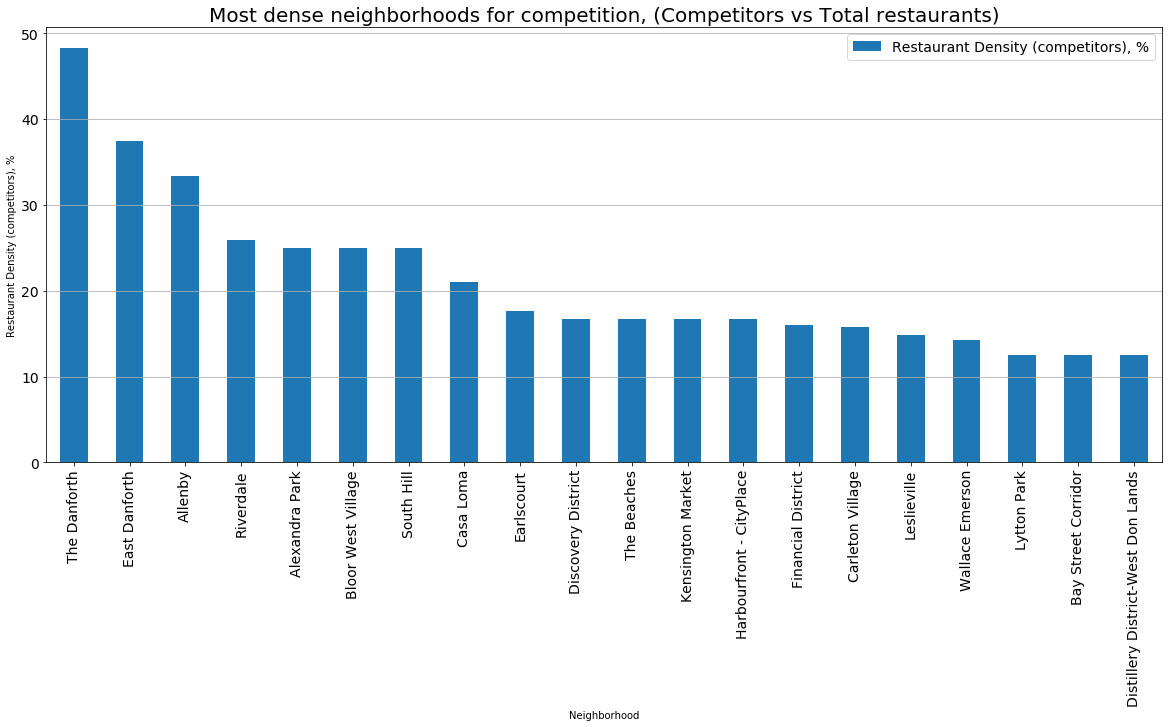

In [16]:
# Calculate factor1: Density of ethnic restaurants (same as language) out of total restaurants (less is best)

# Total number of restaurants and competitors
w1 = Toronto_restaurants_conclude[['Neighborhood','Language','Total Restaurants','Number of Competitors']].copy()

# Density of ethnic restaurants(same as language) out of total restaurants (less is best)
rd1 = ((w1['Number of Competitors'] + 1) / w1['Total Restaurants']) * 100
w1['Restaurant Density (competitors), %'] = (rd1.astype(float)).round(2)
w1 = w1[['Neighborhood','Restaurant Density (competitors), %']].copy()
w1 = w1.sort_values('Restaurant Density (competitors), %',ascending=False).reset_index(drop=True)
# List of the 20 more dense neighborhoods in terms of ethnic restaurants 
# I delete the 1st value because there only 1 restaurant
top20_dense_restaurants = w1.drop(w1.index[0]).head(20)

# Plot
ax = top20_dense_restaurants.plot(kind='bar', figsize=(20, 8), width=0.5)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Restaurant Density (competitors), %')
ax.set_title("Most dense neighborhoods for competition, (Competitors vs Total restaurants)",fontsize=20)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticklabels(top20_dense_restaurants['Neighborhood'])
ax.yaxis.grid(True)

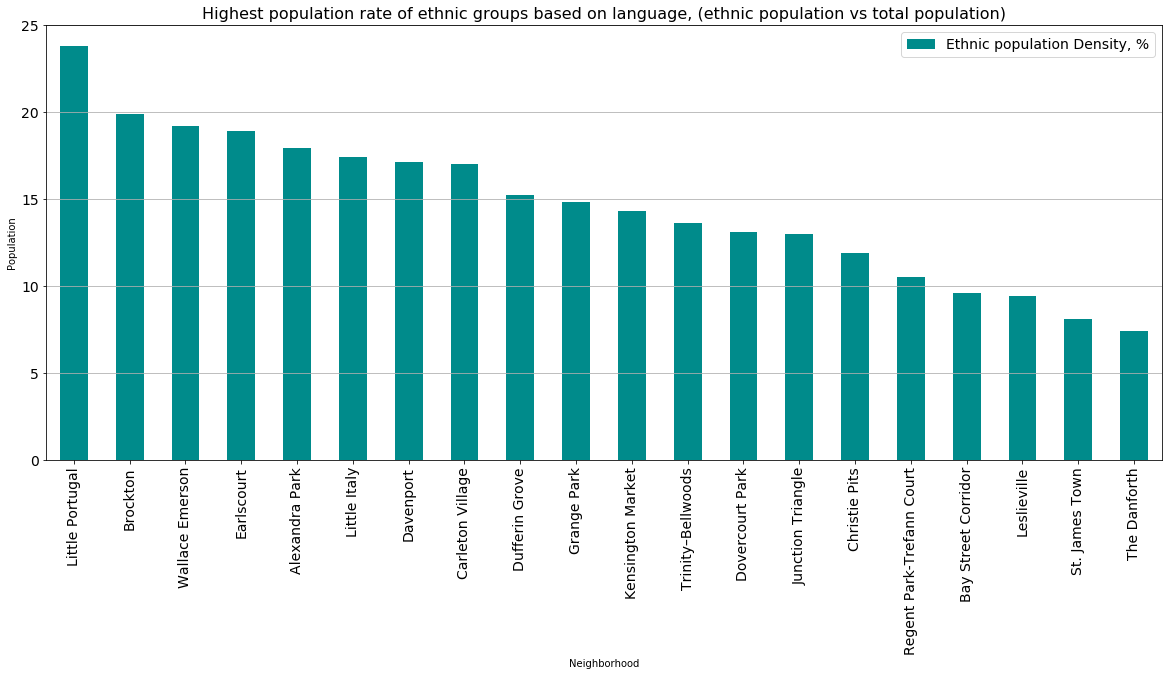

In [17]:
# Calculate factor2: Find the 20 more dense neighborhoods in terms of ethnic restaurants 

# Total number of population and ethnic minority speaking the 2nd most common language
w2 = Toronto_restaurants_conclude[['Neighborhood','Language','Population','Second language population']].copy()

# Density of ethnic population out of total population (less is best)
pd1 = ((w2['Second language population'] + 1) / w2['Population']) * 100
w2['Ethnic population Density, %'] = (pd1.astype(float)).round(2)

w2 = w2[['Neighborhood','Ethnic population Density, %']].copy()
w2 = w2.sort_values('Ethnic population Density, %',ascending=False).reset_index(drop=True)

# List of the 20 more dense neighborhoods in terms of ethnic restaurants
top20_dense_population = w2.head(20)

# Plot
ax = top20_dense_population.plot(kind='bar', figsize=(20, 8), width=0.5, color=['darkcyan','green'])
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Population')
ax.set_title("Highest population rate of ethnic groups based on language, (ethnic population vs total population)",fontsize=16) # add title to the plot
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticklabels(top20_dense_population['Neighborhood'])
ax.yaxis.grid(True)

In [18]:
# Add the density factors to main dataframe

T1 = Toronto_restaurants_conclude.copy()
T1 = pd.merge(T1,w1, on='Neighborhood', how='inner')
T2 = pd.merge(T1,w2, on='Neighborhood', how='inner')
Toronto_restaurants_final = T2.copy()
Toronto_restaurants_final = Toronto_restaurants_final.sort_values(by='Second language population',ascending=False).reset_index(drop=True)
Toronto_restaurants_final.head(10)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %"
0,Earlscourt,Portuguese,17240,3258,17,2,43.678000,-79.449000,17.65,18.90
1,Leslieville,Cantonese,23567,2215,27,3,43.661927,-79.332039,14.81,9.40
2,Riverdale,Cantonese,31007,2077,27,6,43.667750,-79.349610,25.93,6.70
3,Wallace Emerson,Portuguese,10338,1984,21,2,43.663000,-79.441000,14.29,19.20
4,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90
5,Davenport,Portuguese,8781,1501,19,1,43.673000,-79.428000,10.53,17.11
6,Dufferin Grove,Portuguese,9875,1501,29,1,43.657000,-79.428000,6.90,15.21
7,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41
8,Grange Park,Chinese,9007,1333,27,2,43.653000,-79.393000,11.11,14.81
9,Little Portugal,Portuguese,5013,1193,24,1,43.650000,-79.435556,8.33,23.82


In [20]:
# Manually try to find the optimum neighborhood:
# 1) Assume middle-class and above neighborhoods only
# 2) Large population, so to attract as many people as possible
# 3) Large ethnic community, so to have significant cultural characteristics
# 4) Less number of competitors, so to avoid competition as much as possible

T0 = Toronto_restaurants_final.copy()

# 1) Assume above middle-class and upper-class neihborhoods only
income=Toronto[['Neighborhood','Average income']]
Tx = pd.merge(T0, income, how='inner')
Toronto_restaurants_final_income = Tx.copy()

T0 = Tx[Tx['Average income'] > Tx['Average income'].mean()]
Toronto_restaurants_final_income = Tx.copy()

# 2) Large population, so to attract as many people as possible
T1 = T0[T0['Population'] > T0['Population'].mean()]

# 3) Large number of secondary population, i.e. significant ethnic community
T2 = T1[T1['Second language population'] > T0['Second language population'].mean()]

# 4) Less competitors possible
T3 = T2[T2['Restaurant Density (competitors), %'] < T0['Restaurant Density (competitors), %'].mean()]

T_manual = T3.sort_values(by='Restaurant Density (competitors), %')
T_manual

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income
27,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.5,55735
35,The Annex,Spanish,15602,202,35,0,43.670000,-79.404000,2.86,1.3,63636
38,Deer Park,Russian,15165,166,16,0,43.688056,-79.394028,6.25,1.1,80704
28,Swansea,Polish,11133,333,13,0,43.643889,-79.477778,7.69,3.0,58681
22,Forest Hill,Russian,24056,577,11,0,43.700000,-79.416667,9.09,2.4,101631


In [21]:
T = Toronto_restaurants_final_income.copy()

# set number of clusters
kclusters = 5
T_cluster = T.drop(['Neighborhood','Language'],axis=1)

# run k-means clustering
k_means_cat = KMeans(n_clusters=kclusters, random_state=0).fit(T_cluster)

# check cluster labels generated for each row in the dataframe
k_means_cat.labels_[0:10]

#toronto_grouped_clustering_cat
labels_cat = k_means_cat.labels_

# Add cluster labels to main dataframe
T['Cluster Labels'] = labels_cat
Toronto_restaurants_final_income_coords = T.copy()
Toronto_restaurants_final_income_coords.head(10)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Earlscourt,Portuguese,17240,3258,17,2,43.678000,-79.449000,17.65,18.90,26672,3
1,Leslieville,Cantonese,23567,2215,27,3,43.661927,-79.332039,14.81,9.40,30886,3
2,Riverdale,Cantonese,31007,2077,27,6,43.667750,-79.349610,25.93,6.70,40139,1
3,Wallace Emerson,Portuguese,10338,1984,21,2,43.663000,-79.441000,14.29,19.20,25029,3
4,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90,27260,3
5,Davenport,Portuguese,8781,1501,19,1,43.673000,-79.428000,10.53,17.11,28335,3
6,Dufferin Grove,Portuguese,9875,1501,29,1,43.657000,-79.428000,6.90,15.21,27961,3
7,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41,31231,3
8,Grange Park,Chinese,9007,1333,27,2,43.653000,-79.393000,11.11,14.81,35277,3
9,Little Portugal,Portuguese,5013,1193,24,1,43.650000,-79.435556,8.33,23.82,29224,3


In [22]:
Cluster0 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 0]
Cluster0 = Cluster0.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster0.head(10)
# Middle and upper-level, ethnic population is small, except The Annex

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,The Annex,Spanish,15602,202,35,0,43.670000,-79.404000,2.86,1.30,63636,0
1,Fashion District,Portuguese,4642,51,32,0,43.645000,-79.398000,3.12,1.12,63282,0
2,Summerhill,Chinese,5100,56,29,0,43.683000,-79.390000,3.45,1.12,88937,0
3,Chaplin Estates,French,4906,58,33,1,43.700000,-79.400000,6.06,1.20,81288,0
4,Deer Park,Russian,15165,166,16,0,43.688056,-79.394028,6.25,1.10,80704,0
5,Bedford Park,Greek,13749,96,16,1,43.731380,-79.421160,12.50,0.71,80827,0
6,Financial District,Japanese,548,9,25,3,43.647935,-79.381752,16.00,1.82,63952,0
7,The Beaches,Cantonese,20416,142,12,1,43.667266,-79.297128,16.67,0.70,67536,0
8,Casa Loma,Korean,3597,64,38,7,43.670000,-79.410000,21.05,1.81,82203,0


In [23]:
Cluster1 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 1]
Cluster1 = Cluster1.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster1
# High-class, Small ethnic group

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Seaton Village,Portuguese,5259,262,35,0,43.668000,-79.416000,2.86,5.00,41506,1
1,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.50,55735,1
2,Harbord Village,Portuguese,5906,242,33,0,43.661000,-79.406000,3.03,4.11,45792,1
3,Playter Estates,Chinese,3968,71,32,0,43.678056,-79.355556,3.12,1.81,44557,1
4,Bracondale Hill,Greek,5343,256,30,0,43.676000,-79.428030,3.33,4.81,41605,1
5,Niagara,Portuguese,6524,260,26,0,43.643000,-79.408000,3.85,4.00,44611,1
6,Upper Beaches,Cantonese,19830,138,25,0,43.646667,-79.408333,4.00,0.70,44346,1
7,Roncesvalles,Polish,15996,703,23,0,43.646231,-79.449048,4.35,4.40,46820,1
8,High Park North,Polish,22746,682,18,0,43.656000,-79.475000,5.56,3.00,46437,1
9,Wychwood,Portuguese,4182,112,31,1,43.676200,-79.424400,6.45,2.70,53613,1


In [24]:
Cluster2 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 2]
Cluster2 = Cluster2.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster2
# Middle-class (<50K), Davisville(Persian) is good choice with high population, small restaurant density and ethnic-group big enough.

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Rosedale,Chinese,7672,76,23,0,43.646231,-79.449048,4.35,1.00,213941,2
1,Allenby,Russian,2513,35,3,0,43.712750,-79.547460,33.33,1.43,245592,2


In [25]:
Cluster3 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 3]
Cluster3 = Cluster3.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster3
# Upper-class (>100K), although high restaurant density, small ethnic groups, except Forest Hill

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Christie Pits,Portuguese,5124,609,38,0,43.664722,-79.420833,2.63,11.90,30556,3
1,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90,27260,3
2,Regal Heights,Spanish,2719,149,31,0,43.676200,-79.424400,3.23,5.52,36652,3
3,Church and Wellesley,Spanish,13397,241,28,0,43.665694,-79.380956,3.57,1.81,37653,3
4,Parkdale,Polish,28367,822,26,0,43.640454,-79.436731,3.85,2.90,26314,3
5,Trinity–Bellwoods,Portuguese,8687,1181,25,0,43.646667,-79.408333,4.00,13.61,31106,3
6,Dovercourt Park,Portuguese,8497,1113,22,0,43.665000,-79.432000,4.55,13.11,28311,3
7,The Junction,Portuguese,11391,467,20,0,43.665556,-79.464444,5.00,4.11,34906,3
8,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41,31231,3
9,Dufferin Grove,Portuguese,9875,1501,29,1,43.657000,-79.428000,6.90,15.21,27961,3


In [26]:
Cluster4 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 4]
Cluster4 = Cluster4.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster4
# Low and middle-class

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Forest Hill,Russian,24056,577,11,0,43.700000,-79.416667,9.09,2.40,101631,4
1,Yorkville,French,6045,114,38,3,43.670278,-79.391111,10.53,1.90,105239,4
2,Lytton Park,Serbian,6494,58,8,0,43.716000,-79.406000,12.50,0.91,127356,4
3,South Hill,French,6218,62,16,3,43.681000,-79.404000,25.00,1.01,120453,4


In [29]:
# Visualize the neighborhoods per cluster. 

map_Toronto_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]

# Use different colors for each language
colors =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'lightred', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

cluster_name = Toronto_restaurants_final_income_coords['Cluster Labels'].unique()

CLR = dict(zip(cluster_name, colors))

# add markers to the map
markers_colors = []
for lat, lon, poi, lang, cluster in zip(Toronto_restaurants_final_income_coords['Latitude'], 
                                      Toronto_restaurants_final_income_coords['Longitude'], 
                                      Toronto_restaurants_final_income_coords['Neighborhood'],
                                      Toronto_restaurants_final_income_coords['Language'],
                                      Toronto_restaurants_final_income_coords['Cluster Labels']):
    
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup('Cluster:{}, {}({})'.format(cluster,poi,lang),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=(CLR[cluster]),
        fill=True,
        fill_color=(CLR[cluster]),
        fill_opacity=0.7).add_to(map_Toronto_clusters)
       
map_Toronto_clusters

In [30]:
Cluster1_final = Cluster1[Cluster1['Population'] > Cluster1['Population'].mean()]
Cluster1_final = Cluster1_final.sort_values(by='Ethnic population Density, %')
Cluster1_final

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
6,Upper Beaches,Cantonese,19830,138,25,0,43.646667,-79.408333,4.00,0.7,44346,1
1,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.5,55735,1
11,Cabbagetown,Chinese,11120,177,13,0,43.667630,-79.366060,7.69,1.6,50398,1
8,High Park North,Polish,22746,682,18,0,43.656000,-79.475000,5.56,3.0,46437,1
10,Swansea,Polish,11133,333,13,0,43.643889,-79.477778,7.69,3.0,58681,1
7,Roncesvalles,Polish,15996,703,23,0,43.646231,-79.449048,4.35,4.4,46820,1
16,Riverdale,Cantonese,31007,2077,27,6,43.667750,-79.349610,25.93,6.7,40139,1


In [31]:
# The best candidates from all clusters
a = ['The Annex', 'Parkdale', 'Forest Hill', 'Davisville']
df = Toronto_restaurants_final_income_coords[Toronto_restaurants_final_income_coords.Neighborhood.isin(a)]
df.sort_values(by='Average income').reset_index(drop=True)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Parkdale,Polish,28367,822,26,0,43.640454,-79.436731,3.85,2.9,26314,3
1,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.5,55735,1
2,The Annex,Spanish,15602,202,35,0,43.670000,-79.404000,2.86,1.3,63636,0
3,Forest Hill,Russian,24056,577,11,0,43.700000,-79.416667,9.09,2.4,101631,4


In [34]:
# Competitors
map_Toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=13)

def Create_map_competitors (df_coordinates, center_of_map):
    # Use different colors for each language
    clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
           'darkpurple', 'lightred', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

    lang = df_coordinates['Language'].unique()

    CLR = dict(zip(lang,clrs))

    # add markers to map
    for vlat, vlong, nb, lang, vcat in zip(
        df_coordinates['Venue Latitude'], 
        df_coordinates['Venue Longitude'], 
        df_coordinates['Neighborhood'],
        df_coordinates['Language'],
        df_coordinates['Venue Category']):
       
        label = folium.Popup('{}({}), {}'.format(nb,lang,vcat),parse_html=True)
        folium.Marker(
            location=[vlat,vlong],
            popup= label,
            icon=folium.Icon(CLR[lang])
        ).add_to(center_of_map) 

# Visualize the competition for Cluster 2 neighborhoods
Cluster1_comptetitors = pd.merge(Cluster1_final, Toronto_restaurants_coord_lang, how='inner')

Create_map_competitors(Cluster1_comptetitors, map_Toronto)

map_Toronto

## End of the script
***
Thanks for reading !